In [ ]:
import matplotlib.pyplot as plt
from src.invert_c_theta import Invert
import pandas as pd
import firedrake
import numpy as np

In [ ]:
drichlet_ids = [2,3,4]
side_ids = []
invert_pig = Invert(outline = 'pine-island', mesh_name = 'pig', reg_constant_simultaneous = 1, read_mesh = False,opts = None, drichlet_ids = drichlet_ids , lcar = 9e3)

In [ ]:
invert_pig.plot_mesh()

In [ ]:
invert_pig.import_velocity_data(constant_val=0.01)
invert_pig.import_geophysics_data(name_list=['data/geophysics/ADMAP_MagneticAnomaly_5km.tif', 
                                                'data/geophysics/ANTGG_BouguerAnomaly_10km.tif', 
                                                'data/geophysics/GeothermalHeatFlux_5km.tif',
                                                'data/geophysics/ALBMAP_SurfaceAirTemperature_5km.tif',
                                                'data/geophysics/EIGEN-6C4_GravityDisturbance_10km.tif',
                                                'data/geophysics/ALBMAP_SnowAccumulation_Arthern_5km.tif',])

In [ ]:
u =  invert_pig.simulation()
firedrake.assemble(invert_pig.loss_functional_nosigma(u))

In [ ]:
invert_pig.plot_u_error_no_sigma(u, vmax = 100)

In [ ]:
invert_pig.plot_u_error_percentage(u, vmax = 10)

In [8]:
invert_pig.default_u = u

In [9]:
df = invert_pig.get_dataframe(u)
df.to_csv('pig_baseline_geo_12_loop.csv')

In [ ]:
invert_pig.invert_C_theta_simultaneously(max_iterations=300, regularization_grad_fcn= True, loss_fcn_type = 'regular')

In [11]:
u_optimized =  invert_pig.simulation()

In [ ]:
firedrake.assemble(invert_pig.loss_functional_nosigma(u_optimized))

In [ ]:
invert_pig.plot_u_error_no_sigma(u_optimized, vmax = 100)

In [ ]:
invert_pig.plot_u_error_percentage(u_optimized, vmax = 10)

In [ ]:
invert_pig.plot_u_mag(u_optimized, vmax = 1000)

In [ ]:
invert_pig.plot_streamline_u(u_optimized)

In [ ]:
invert_pig.plot_C(vmax = 3)

In [ ]:
invert_pig.plot_theta(vmin = -5, vmax = 5)

In [ ]:
invert_pig.plot_C_total(vmax = 0.1)

In [ ]:
invert_pig.plot_grounding_line()

In [21]:
#invert_pig.inverse_u = invert_pig.u_initial
invert_pig.inverse_u = u_optimized

In [22]:
theta = invert_pig.θ
C = invert_pig.C

In [23]:
df = invert_pig.get_dataframe(u_optimized)
df.to_csv('regularized_const_01C_simultaneous_pig_r1_geo_12_loop.csv')

In [ ]:
mean_value_C = 1.0399764933270377
invert_pig.C.dat.data[:] = np.ones(invert_pig.C.dat.data[:].shape) * mean_value_C
u_avg = invert_pig.simulation()
print(firedrake.assemble(invert_pig.loss_functional_nosigma(u_avg)))
invert_pig.default_u = u_avg

In [27]:
invert_pig.opts = {"dirichlet_ids": invert_pig.drichlet_ids,
                    "side_wall_ids": invert_pig.side_ids,
                   "diagnostic_solver_type": "icepack",
                "diagnostic_solver_parameters": {
                    "max_iterations":50,},}
invert_pig.create_model_weertman()

In [ ]:
import os
import copy
import pickle


base_folder = 'mlp_ensemble'
summary_list = []
class_list = []
u_optimized_list = []
loss_function_list = []

error_list = []
columns_list = []
df_summary_list = []

# Collect all temp objects for later plotting
temp_objects = []

for folder in os.listdir(base_folder):
    if not os.path.isdir(os.path.join(base_folder, folder)):
        continue  # Skip if not a directory
    
    try:
        # Skip folders that don't contain numeric names (if needed)
        folder_num = int(folder)
    except ValueError:
        continue
    
    print('Processing folder:', folder)
    path = os.path.join(base_folder, folder)
    files = [f for f in os.listdir(path) if f.endswith('.pkl')]
    
    if not files:
        print(f"No .pkl files found in folder {folder}. Skipping.")
        continue
    
    temp_object = copy.copy(invert_pig)
    columns = None
    r2_list, r2_adjusted_list, mse_list = [], [], []
    
    for file in files:
        try:
            with open(os.path.join(path, file), "rb") as f:
                model_bundle = pickle.load(f)
                r2_list.append(model_bundle['r2_test'])
                r2_adjusted_list.append(model_bundle['r2_adjusted_test'])
                mse_list.append(model_bundle['mse_test'])
                columns = model_bundle.get('input_columns', columns)
        except Exception as e:
            print(f"Error processing file {file} in folder {folder}: {e}")
            continue
    if r2_list and r2_adjusted_list and mse_list:
        r2_stats = pd.DataFrame(r2_list).describe()
        r2_adjusted_stats = pd.DataFrame(r2_adjusted_list).describe()
        mse_stats = pd.DataFrame(mse_list).describe()
        
        summary_list.append({
            'input_columns': columns,
            'r2_mean': r2_stats.loc['mean'].values[0],
            'r2_std': r2_stats.loc['std'].values[0],
            'r2_median': r2_stats.loc['50%'].values[0],
            'r2_adjusted_mean': r2_adjusted_stats.loc['mean'].values[0],
            'r2_adjusted_std': r2_adjusted_stats.loc['std'].values[0],
            'r2_adjusted_median': r2_adjusted_stats.loc['50%'].values[0],
            'mse_mean': mse_stats.loc['mean'].values[0],
            'mse_std': mse_stats.loc['std'].values[0],
            'mse_median': mse_stats.loc['50%'].values[0]
        })
    

    model_name = files[0][:-8]  # Assumes model files end with a fixed pattern (e.g., '_model.pkl')
    print(model_name)
    print(columns)
    columns_list.append(columns)
    
    # Ensure the model_name is properly constructed
    model_file_path = os.path.join(base_folder, folder, model_name)
    temp_object.compute_C_ML_regress(
        filename=model_file_path, 
        half=False, 
        flip=False, 
        use_driving_stress=False, 
        C_bounds=[-50, 55], 
        θ_bounds=[-102, 200],
        folder = '', 
        number_of_models=10
    )
    
    u_optimized = temp_object.simulation()
    # Store or process `u_optimized` as needed
    u_optimized_list.append(u_optimized)
    loss_val = firedrake.assemble(temp_object.loss_functional_nosigma(u_optimized))
    loss_function_list.append(loss_val)
    temp_object.ML_u = u_optimized
    # Collect the temp object for plotting later
    temp_objects.append(temp_object)
    

In [ ]:
temp_object.cluster_df_full.columns

['b', 'mag_b', 'heatflux']
R2 test: 0.15141888665016698
R2_adjusted test: 0.15139825546898125
MSE test: 0.00013070108169867186
Loss function value: 3965303.44433232


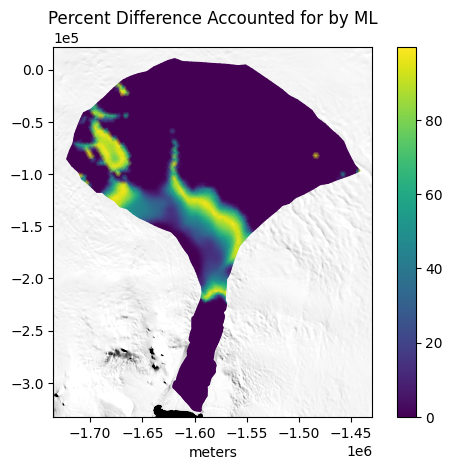

['heatflux', 'gravity_disturbance']
R2 test: -0.1301840863061469
R2_adjusted test: -0.13020240460503185
MSE test: 0.00015089182307118418
Loss function value: 1566952.4476969545


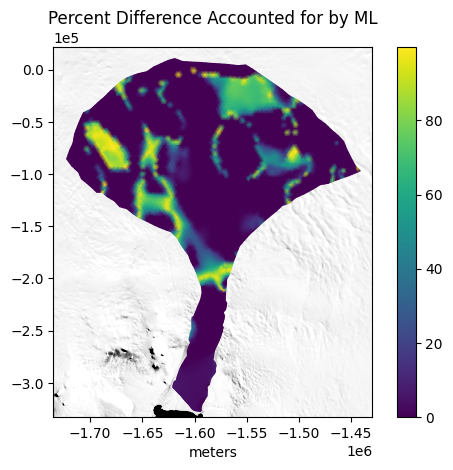

['b', 'mag_b', 'mag_anomaly', 'heatflux', 'gravity_disturbance']
R2 test: 0.5120815965417072
R2_adjusted test: 0.5120618253102778
MSE test: 7.225218579285763e-05
Loss function value: 3617660.625857372


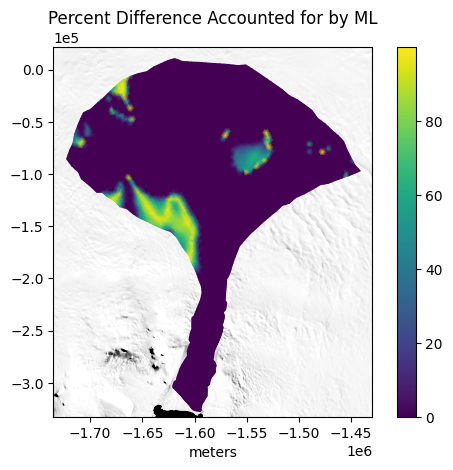

['s', 'b', 'h', 'mag_h', 'mag_s', 'mag_b', 'driving_stress', 'heatflux', 'snow_accumulation', 'surface_air_temp', 'gravity_disturbance']
R2 test: 0.8071760673926315
R2_adjusted test: 0.8071588767838971
MSE test: 4.019283729303365e-05
Loss function value: 7449675.459366538


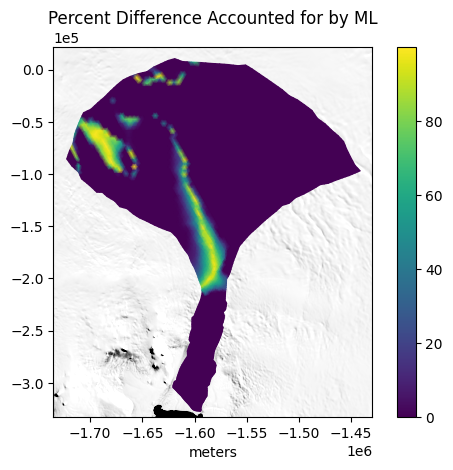

['s', 'h', 'mag_h', 'mag_s', 'driving_stress']
R2 test: 0.022165935846486982
R2_adjusted test: 0.022126312451581566
MSE test: 0.00012189780313980511
Loss function value: 543044.0218534162


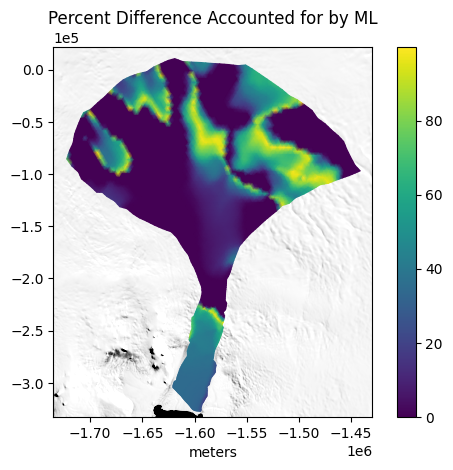

['b', 'mag_b', 'mag_anomaly', 'gravity_disturbance']
R2 test: -0.10172558509126613
R2_adjusted test: -0.10176129974327246
MSE test: 0.00013650378450149052
Loss function value: 413496.65120902733


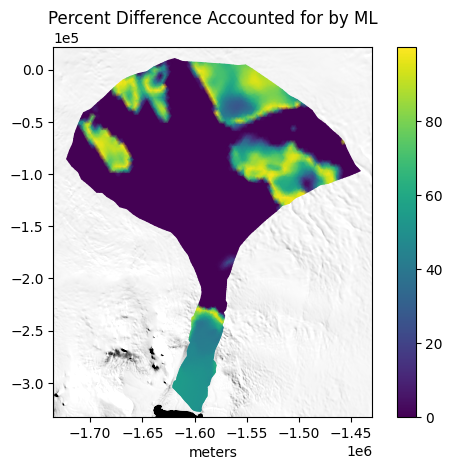

['s', 'h', 'mag_h', 'mag_s', 'driving_stress', 'snow_accumulation', 'surface_air_temp']
R2 test: 0.42408071427809035
R2_adjusted test: 0.42404804171408494
MSE test: 9.416472373557543e-05
Loss function value: 735204.9885809299


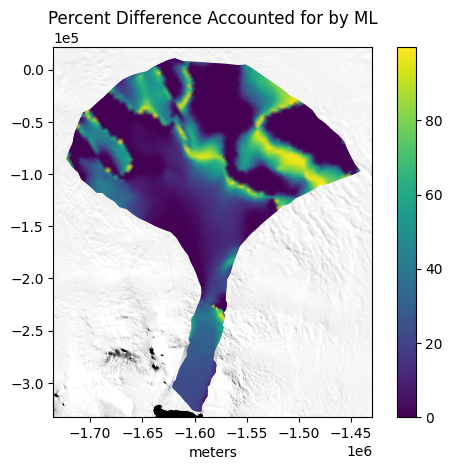

['b', 'mag_b', 'heatflux', 'gravity_disturbance']
R2 test: 0.5371337490253499
R2_adjusted test: 0.5371187442843303
MSE test: 8.136718578996773e-05
Loss function value: 4191883.554272077


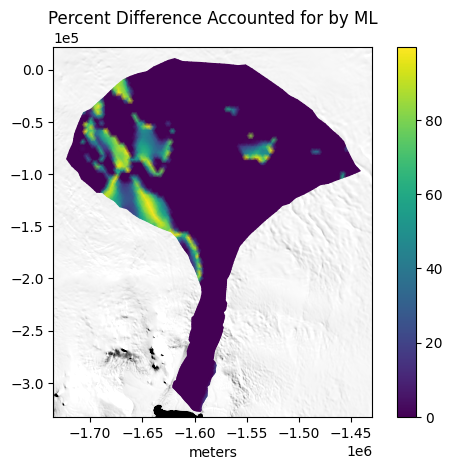

['driving_stress', 'snow_accumulation', 'surface_air_temp']
R2 test: -38.880884596753326
R2_adjusted test: -38.8818542032447
MSE test: 0.00025625363192406604
Loss function value: 1227285.652301608


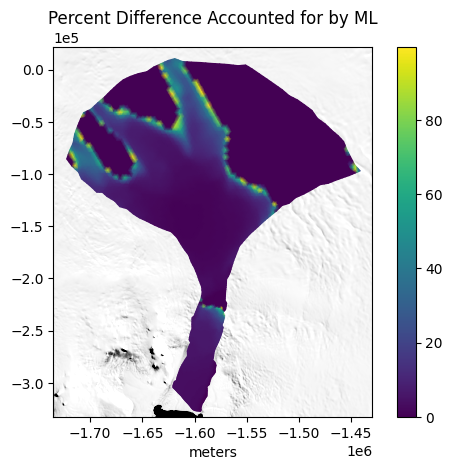

['s', 'b', 'h', 'mag_h', 'mag_s', 'mag_b', 'driving_stress', 'mag_anomaly', 'heatflux', 'snow_accumulation', 'surface_air_temp', 'gravity_disturbance']
R2 test: 0.889809317808157
R2_adjusted test: 0.8897986009551915
MSE test: 2.5396723867938764e-05
Loss function value: 7109511.744852111


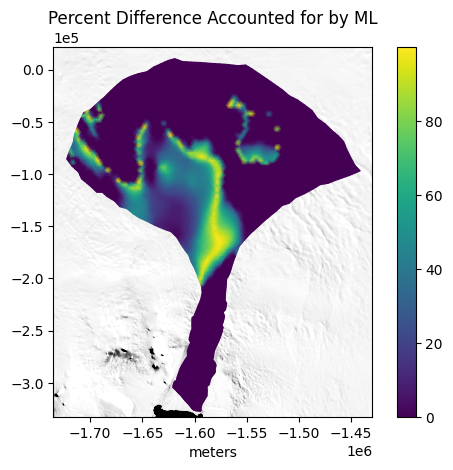

['mag_h', 'mag_s']
R2 test: -4.973258095544954
R2_adjusted test: -4.97335491156673
MSE test: 0.00023863772477964433
Loss function value: 741743.1153059577


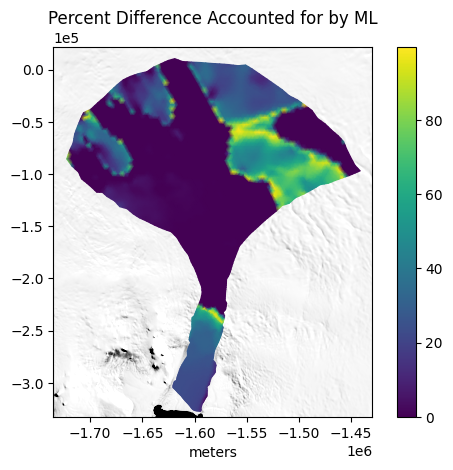

['s', 'h', 'mag_h', 'mag_s']
R2 test: 0.5341037142672549
R2_adjusted test: 0.5340886113015608
MSE test: 8.991990059537454e-05
Loss function value: 598467.8763874159


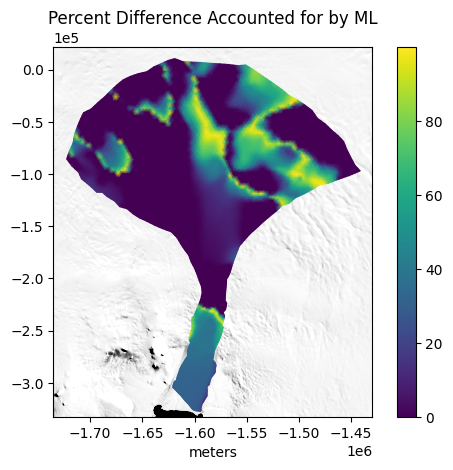

['b', 'mag_b', 'gravity_disturbance']
R2 test: -2.227666672375533
R2_adjusted test: -2.227745145222592
MSE test: 0.0002067412766328459
Loss function value: 498561.7961489388


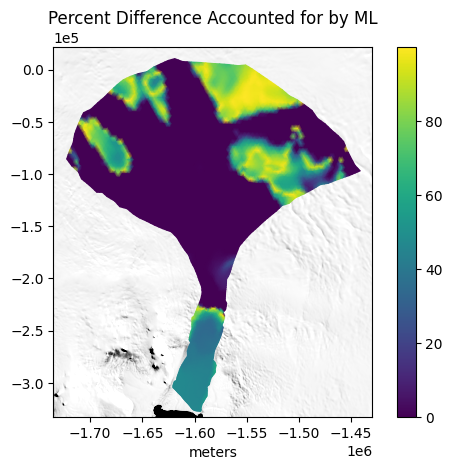

['s', 'h', 'mag_h', 'mag_s', 'snow_accumulation']
R2 test: 0.3009470717441717
R2_adjusted test: 0.30091874500525806
MSE test: 0.00011212609930310268
Loss function value: 718404.216550871


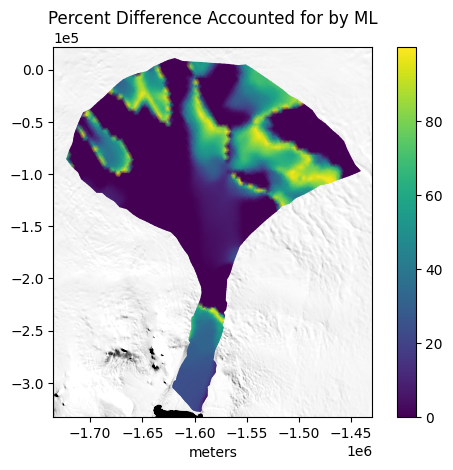

['s', 'h', 'mag_h', 'mag_s', 'surface_air_temp']
R2 test: 0.7323474850057237
R2_adjusted test: 0.7323366392991895
MSE test: 5.110743912025452e-05
Loss function value: 728012.7016432317


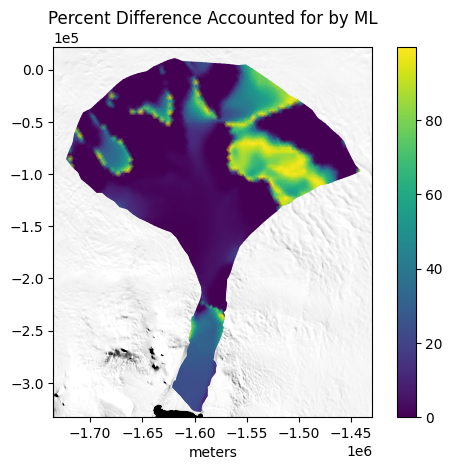

['s', 'h']
R2 test: -1.7808141794261316
R2_adjusted test: -1.7808592515395152
MSE test: 0.00021589937121152224
Loss function value: 319963.16050008265


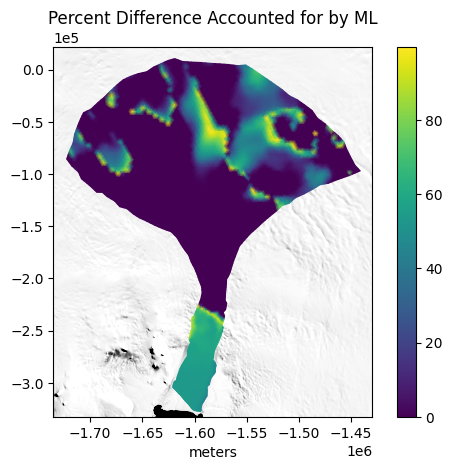

In [38]:
for i, temp_object in enumerate(temp_objects):
    
    print(columns_list[i])
    print('R2 test:', summary_list[i]['r2_mean'])
    print('R2_adjusted test:', summary_list[i]['r2_adjusted_mean'])
    print('MSE test:', summary_list[i]['mse_mean'])
    print('Loss function value:', loss_function_list[i])
    temp_object.plot_percent_accounted(vmin=0)